In [101]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re 

In [102]:
# import and analyse dataset
labels = pd.read_csv('labels_and_ids.csv')
labels.groupby('jericho_human_classification').size()

jericho_human_classification
ham      590
phish     22
spam     539
dtype: int64

In [103]:
# flatten inbound_event_ids
labels.loc[:, 'inbound_event_ids'] = labels['inbound_event_ids'].apply(lambda x: x.removeprefix('[').removesuffix(']').split(','))
labels = labels.explode('inbound_event_ids')
# remove duplicates
labels = labels.drop_duplicates(subset='inbound_event_ids')
# convert inbound_event_ids to int
labels.loc[:, 'inbound_event_ids'] = labels['inbound_event_ids'].astype(int)
# down sample to match phish
ham_labels = labels[labels['jericho_human_classification'] == 'ham']
spam_labels = labels[labels['jericho_human_classification'] == 'spam']
phish_labels = labels[labels['jericho_human_classification'] == 'phish']
print(ham_labels.shape, spam_labels.shape, phish_labels.shape)
ham_labels = ham_labels.sample(n=phish_labels.shape[0], random_state=42)
spam_labels = spam_labels.sample(n=phish_labels.shape[0], random_state=42)
labels = pd.concat([ham_labels, spam_labels, phish_labels])
labels.info()
# save to ids to text
for i in labels['inbound_event_ids']:
    with open('ids.txt', 'a') as f:
        f.write(f'{i},')


(728, 3) (556, 3) (25, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 114 to 1148
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            75 non-null     int64 
 1   jericho_human_classification  75 non-null     object
 2   inbound_event_ids             75 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB


In [104]:
obj_df = pd.read_csv('email_data.csv')
# merge with labels
obj_df = obj_df.merge(labels, left_on='id', right_on='inbound_event_ids')
obj_df = obj_df.drop(columns=['id_x', 'id_y'])
obj_df['processed_body'] = obj_df['processed_body'].astype(str)
obj_df['processed_subject'] = obj_df['processed_subject'].astype(str)
obj_df['jericho_human_classification'] = obj_df['jericho_human_classification'].astype(str)
obj_df['inbound_event_ids'] = obj_df['inbound_event_ids'].astype(int)
obj_df.head()

,from,processed_subject,processed_body,payload,jericho_human_classification,inbound_event_ids
0,no-reply@rentaequipospiedra.cl,9192-Jerichosecurity: Accept the proposal and ...,Docusign He‌llo sage@jerichosecurity.com\nYo‌u...,"{""cc"":"""",""to"":""sage@jerichosecurity.com"",""bcc""...",phish,208
1,deep@beeleads.com,Life of a Prospect- A Journey of Multiple Purc...,Life of a Prospect- A Journey of Multiple Purc...,"{""cc"":"""",""to"":""alyssa.davis@jerichosecurity.co...",spam,402
2,no-reply@zoom.us,Ahmad Anderson has joined your meeting - Sales...,"Hi Madison Martin, Ahmad Anderson has joined...","{""cc"":"""",""to"":""madison@jerichosecurity.com"",""b...",ham,501
3,telmalogistics@gmail.com,Sage Wohns,Chris\n---\n\nI need you to kindly leave your ...,"{""cc"":"""",""to"":""chris@jerichosecurity.com"",""bcc...",phish,509
4,attendurgent@gmail.com,Sage Wohns,"Hello Chris,\n\n I have a task for you to comp...","{""cc"":"""",""to"":""chris@jerichosecurity.com"",""bcc...",phish,638


In [105]:
# preparation of data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
encoder = LabelEncoder()
link_formats = ["http", "https"]
def remove_links(links, text):
    text_without_links = text
    for link in links:
        text_without_links = re.sub("^" + link + "[\s\n]$", "", text_without_links)
    return text_without_links
def remove_tags(text):
    text = re.sub('<[^<]+?>', '', text)
    return text
def simplify_text(text):
    text = text.lower()
    text = remove_links(link_formats, text)
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    # remove non text characters
    text = ''.join([i for i in text if i.isalnum() or i == ' '])
    return text
def count_generic_greeting(text):
    count = 0
    generic_references = [
    "customer",
    "friend",
    "user",
    "sir",
    "madam",
    "member",
    "client",
    "beneficiary",
    "subscriber",
    "account holder",
    "colleague",
    "team member",
    "partner",
    "recipient",
    "patron"
    ]
    for ref in generic_references:
        count += text.lower().count(ref)
    return count
# def has_pdf(text):
#     return 1 if ".pdf" in text else 0
# def image_count(text):
#     image_suffixes = [".jpg", ".jpeg", ".png", ".gif", ".bmp"]
#     count = 0
#     for suffix in image_suffixes:
#         count += text.count(suffix)
#     return count

obj_df['processed_body'] = obj_df['processed_body'].apply(simplify_text)
obj_df['processed_subject'] = obj_df['processed_subject'].apply(simplify_text)
obj_df['jericho_human_classification'] = encoder.fit_transform(obj_df['jericho_human_classification'])
sender = obj_df['from'].apply(lambda x: x.split('@')[0])
sender_domain = obj_df['from'].apply(lambda x: x.split('@')[1])
sender = CountVectorizer().fit_transform(sender)
sender_domain = CountVectorizer().fit_transform(sender_domain)
vectorized_subject = CountVectorizer().fit_transform(obj_df['processed_subject'])
vectorized_body = CountVectorizer().fit_transform(obj_df['processed_body'])

# additional features
has_noreply = obj_df['payload'].apply(lambda x: 1 if 'noreply' in x else 0)
spf_pass = obj_df['payload'].apply(lambda x: 1 if 'spf=pass' in x else 0)
spf_fail = obj_df['payload'].apply(lambda x: 1 if 'spf=fail' in x else 0)
dkim_pass = obj_df['payload'].apply(lambda x: 1 if 'dkim=pass' in x else 0)
dkim_fail = obj_df['payload'].apply(lambda x: 1 if 'dkim=fail' in x else 0)
dmarc_pass = obj_df['payload'].apply(lambda x: 1 if 'dmarc=pass' in x else 0)
dmarc_fail = obj_df['payload'].apply(lambda x: 1 if 'dmarc=fail' in x else 0)
has_pdf = obj_df['payload'].apply(lambda x: 1 if ".pdf" in x else 0)
image_count = obj_df['payload'].apply(lambda x: sum([x.count(suffix) for suffix in [".jpg", ".jpeg", ".png", ".gif", ".bmp"]]))
generic_greetings = obj_df['processed_body'].apply(count_generic_greeting)

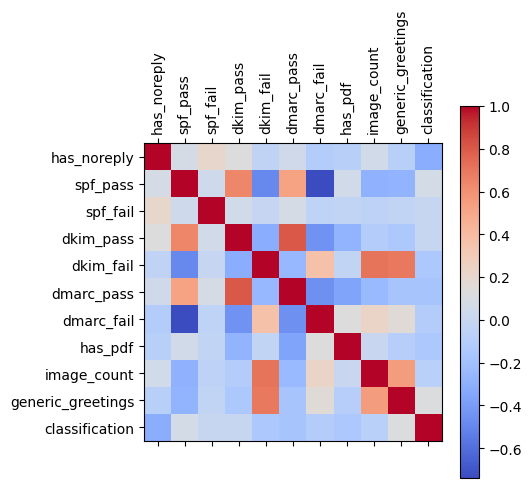

In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

dataset = pd.DataFrame({ 'has_noreply': has_noreply,
                        'spf_pass': spf_pass,
                        'spf_fail': spf_fail,
                        'dkim_pass': dkim_pass,
                        'dkim_fail': dkim_fail,
                        'dmarc_pass': dmarc_pass,
                        'dmarc_fail': dmarc_fail,
                        'has_pdf': has_pdf,
                        'image_count': image_count,
                        'generic_greetings': generic_greetings,
                        'classification': obj_df['jericho_human_classification']})
corr = dataset.corr()
plt.matshow(corr, cmap='coolwarm')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
cb = plt.colorbar()
# show column names

In [107]:
# only engineered features
X = np.concatenate([has_noreply.values.reshape(-1, 1),spf_pass.values.reshape(-1, 1),spf_fail.values.reshape(-1, 1),dkim_pass.values.reshape(-1, 1),dkim_fail.values.reshape(-1, 1),dmarc_pass.values.reshape(-1, 1),dmarc_fail.values.reshape(-1, 1), has_pdf.values.reshape(-1,1), image_count.values.reshape(-1,1), generic_greetings.values.reshape(-1, 1)], axis=1)
y = dataset['classification']
y_pred = []
y_true = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred.extend(model.predict(X_test))
    y_true.extend(y_test)
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

         ham       0.72      0.52      0.60        25
       phish       0.57      0.96      0.72        25
        spam       0.47      0.28      0.35        25

    accuracy                           0.59        75
   macro avg       0.59      0.59      0.56        75
weighted avg       0.59      0.59      0.56        75



In [108]:
# only sender information
X = np.concatenate([sender.toarray(), sender_domain.toarray()], axis=1)
y = dataset['classification']
y_pred = []
y_true = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred.extend(model.predict(X_test))
    y_true.extend(y_test)
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

         ham       0.74      0.56      0.64        25
       phish       0.46      0.96      0.62        25
        spam       0.75      0.12      0.21        25

    accuracy                           0.55        75
   macro avg       0.65      0.55      0.49        75
weighted avg       0.65      0.55      0.49        75



In [109]:
# only email contents
X = np.concatenate([vectorized_subject.toarray(), vectorized_body.toarray()], axis=1)
y = dataset['classification']
y_pred = []
y_true = []
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred.extend(model.predict(X_test))
    y_true.extend(y_test)
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

         ham       0.73      0.44      0.55        25
       phish       0.63      0.88      0.73        25
        spam       0.76      0.76      0.76        25

    accuracy                           0.69        75
   macro avg       0.71      0.69      0.68        75
weighted avg       0.71      0.69      0.68        75



In [112]:
# all features
engineered_features = np.concatenate([has_noreply.values.reshape(-1, 1),spf_pass.values.reshape(-1, 1),spf_fail.values.reshape(-1, 1),dkim_pass.values.reshape(-1, 1),dkim_fail.values.reshape(-1, 1),dmarc_pass.values.reshape(-1, 1),dmarc_fail.values.reshape(-1, 1),generic_greetings.values.reshape(-1, 1)], axis=1)
X = np.concatenate([engineered_features, sender.toarray(), sender_domain.toarray(), vectorized_subject.toarray(), vectorized_body.toarray()], axis=1)
y = dataset['classification']

scores = []

# import models
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# from sklearn.naiive_bayes import MultinomialNB

model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,10,100]
        }
    },
    'naive_bayes *mulnb': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1.0, 5.0]
        }
    }
}

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    # pipe = Pipeline([('clf', clf)])
    pipe = Pipeline([('select', SelectFromModel(RandomForestClassifier(n_estimators=100))), ('clf', clf)])
    pipe.fit(X, y)
    y_pred = pipe.predict(X)
    f1 = f1_score(y, y_pred, average='weighted')
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'f1_score': f1
    })
    

df = pd.DataFrame(scores,columns=['model','best_score','best_params','f1_score'])
print(df)

                 model  best_score            best_params  f1_score
0        random_forest    0.786667  {'n_estimators': 100}       1.0
1   naive_bayes *mulnb    0.866667         {'alpha': 0.1}       1.0
2  logistic_regression    0.800000             {'C': 1.0}       1.0
